In [ ]:
pip install sklearn_crfsuite

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 965 kB 30.1 MB/s 


In [ ]:
pip install highlight_text

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


f1_score: 0.9929243005608631
precision: 0.9936503708069115
recall: 0.9922180834657999
bio_classification_report: 
               precision    recall  f1-score   support

      B-LOC
       0.99      0.99      0.99      8807
      I-LOC
       0.99      0.99      0.99      1414
     B-MISC
       1.00      0.98      0.99      4139
     I-MISC
       0.98      0.99      0.98      1371
          O
       1.00      1.00      1.00    207885
      B-ORG
       0.99      0.99      0.99      7978
      I-ORG
       0.99      0.99      0.99      4539
      B-PER
       1.00      0.99      1.00      8217
      I-PER
       0.99      1.00      1.00      5684

   micro avg       1.00      1.00      1.00    250034
   macro avg       0.99      0.99      0.99    250034
weighted avg       1.00      1.00      1.00    250034
 samples avg       1.00      1.00      1.00    250034



accuracy: 0.998456209955446


[['B-MISC\n', 'I-MISC\n', 'I-MISC\n', 'I-MISC\n', 'I-MISC\n']]

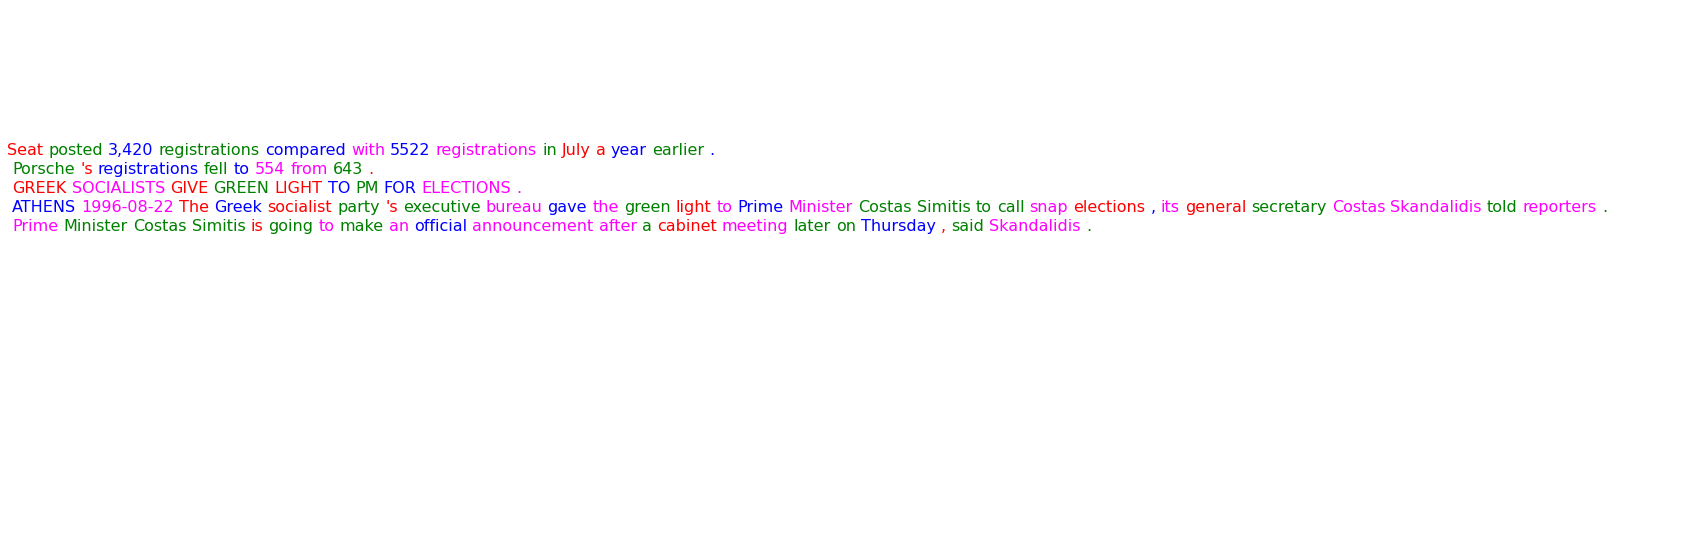

In [ ]:
import sklearn_crfsuite
import nltk
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import random
import scipy.stats
import pickle
from sklearn_crfsuite import metrics
from itertools import chain
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import make_scorer
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from highlight_text import HighlightText, ax_text, fig_text
from sklearn_crfsuite import scorers
from sklearn.preprocessing import LabelBinarizer
from google.colab import drive

nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

class ner: 
    def __init__(self, word, pos_tag, chunk_tag, ner_tag): 
        self.word = word 
        self.pos_tag = pos_tag
        self.chunk_tag = chunk_tag
        self.ner_tag = ner_tag
        
data = []
   
def read_data(filepath):    
    with open(filepath, encoding="utf-8") as f:
        sentence = []
        for line in f:
            if line.startswith("-DOCSTART-") or line == "" or line == "\n":
                continue
            else:
                splits = line.split(" ")
                sentence.append(ner(splits[0], splits[1], splits[2], splits[3]))
                if(splits[0] == "."):
                    data.append(sentence)
                    sentence = []
    return data

#as crf considers the tag of the word coming before a particular word, this is how we have built the features
def features_from_words(sentence, i):
    word = sentence[i].word
    part_of_speech_tag = sentence[i].pos_tag
    features = {
        'bias': 1.0,
        'word in lower case': word.lower(),
        'word[-3:]': word[-3:],
        'word[-2:]': word[-2:],
        'is word capital?': word.isupper(),
        'is word a title?': word.istitle(),
        'is word a digit?': word.isdigit(),
        'part of speech tag': part_of_speech_tag,
        'postag[:2]': part_of_speech_tag[:2],
    }
    if i > 0:
        word1 = sentence[i-1].word
        part_of_speech_tag1 = sentence[i-1].pos_tag
        features.update({
            '-1:word in lower case': word1.lower(),
            '-1:is word a title?': word1.istitle(),
            '-1:is word capital?': word1.isupper(),
            '-1:part of speech tag': part_of_speech_tag1,
            '-1:postag[:2]': part_of_speech_tag1[:2],
        })
    else:
        features['BOS'] = True
    if i < len(sentence)-1:
        word1 = sentence[i+1].word
        part_of_speech_tag1 = sentence[i+1].pos_tag
        features.update({
            '+1:word in lower case': word1.lower(),
            '+1:is word a title': word1.istitle(),
            '+1:is word in upper case': word1.isupper(),
            '+1:part of speech tag': part_of_speech_tag1,
            '+1:postag[:2]': part_of_speech_tag1[:2],
        })
    else:
        features['EOS'] = True
    return features

def features_from_sentence(sentence):
    return [features_from_words(sentence, i) for i in range(len(sentence))]

def labels_from_sentence(sentence):
    return [s.ner_tag for s in sentence]

#assign part of speech tags to the custom input
def pos_tags(document):
        sentences = nltk.sent_tokenize(document) 
        sentences = [nltk.word_tokenize(sentence) for sentence in sentences]
        sentences = [nltk.pos_tag(sentence) for sentence in sentences]
        return sentences

#test a cutom sentence
def test_custom_sentence(sentence):
  sentence = pos_tags(sentence)
  prediction = crf.predict(sentence)
  return prediction

#bio-classification report
def bio_classification_report(y_true, y_pred):
    label_binarizer = LabelBinarizer()
    y_true_combined = label_binarizer.fit_transform(list(chain.from_iterable(y_true)))
    y_pred_combined = label_binarizer.transform(list(chain.from_iterable(y_pred)))
        
    ner_tags = set(label_binarizer.classes_) - {'O'}
    ner_tags = sorted(ner_tags, key=lambda tag: tag.split('-', 1)[::-1])
    class_indices = {cls: idx for idx, cls in enumerate(label_binarizer.classes_)}
    
    return classification_report(
        y_true_combined,
        y_pred_combined,
        labels = [class_indices[name_tag] for name_tag in ner_tags],
        target_names = ner_tags,
    )
  
TRAINING_FILE = "train.txt"
TEST_FILE = "test.txt"

#read the train and test files (pre-processing)
train = read_data(TRAINING_FILE)
test = read_data(TEST_FILE)

X_train = [features_from_sentence(s) for s in train]
X_test = [features_from_sentence(s) for s in test]

y_train = [labels_from_sentence(s) for s in train]
y_test = [labels_from_sentence(s) for s in test]

#train the model
crf = sklearn_crfsuite.CRF(
    algorithm='lbfgs',
    c1=0.1,
    c2=0.1,
    max_iterations=100,
    all_possible_transitions=True
)

crf.fit(X_train, y_train)

with open('crf.pkl', 'wb') as handle:
    pickle.dump(crf, handle, protocol=pickle.HIGHEST_PROTOCOL)
crf2 = pickle.load(open('/content/crf.pkl','rb'))

labels = list(crf.classes_)
labels.remove('O\n')

y_pred = crf2.predict(X_test)

#model results
print('f1_score:', metrics.flat_f1_score(y_test, y_pred, average='weighted', labels=labels))

print('precision:', metrics.flat_precision_score(y_test, y_pred, average='weighted', labels=labels))

print('recall:', metrics.flat_recall_score(y_test, y_pred, average='weighted', labels=labels))

print('bio_classification_report: \n', bio_classification_report(y_test, y_pred))

print('accuracy:', metrics.flat_accuracy_score(y_test, y_pred))

fig, ax = plt.subplots(figsize=(30,10))
font = {'family' : 'normal',
        'size'   : 16}
matplotlib.rc('font', **font)
final_text = []
color = []
samples = 5
index_to_predict = random.randint(0,500)
prediction = crf2.predict(X_test[index_to_predict:index_to_predict+samples])
for x,y in zip(test[index_to_predict:index_to_predict+samples], prediction):
    for x1,y1, in zip(x,y):
        if y1!='O':
            final_text.append('<{}>'.format(x1.word))
            if y1[0]=='I':
                color.append(color[-1])
            else:
                  color.append ({'color':random.choice(['blue','green','red','magenta'])})
        else:
            final_text.append(x1.word)
    final_text.append('\n')
HighlightText(x=0, y=0.75,
              s=' '.join(final_text),
              highlight_textprops=color,
              ax=ax)
plt.axis('off')

#custom sentence
custom_sentence = "John went to China."
test_custom_sentence(custom_sentence)